## **SPOT Phenol Predictions** 

By Garrett Roell and Christina Schenk

Tested on biodesign_3.7 kernel on jprime

This notebook performs SPOT calculations for R. opacus in phenol and creates plots to compare the results with experimental data.                                               
### Method: 
<ol>
<li>Set up imports</li>
<li>Load model and relevant data</li>
<li>Calculate wildtype and PVHG6 phenol SPOT solutions</li>
<li>Compare wildtype phenol SPOT flux predictions with 13C-MFA fluxes</li>
<li>Compare PVHG6 phenol SPOT flux predictions with 13C-MFA fluxes</li>
<li>Generate wildtype and PVHG6 SPOT flux maps</li>
<li>Add wildtype and PVHG6 SPOT phenol data to growth parameters data</li>
</ol>


### 1. Set up imports

In [1]:
import cobra
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from utils import *
from cobra_functions import get_SPOT_solution
from plot import *

output_dir = '../plots/'

### 2. Load model and relevant data

In [2]:
model = cobra.io.read_sbml_model("../models/r_opacus_annotated_curated.xml")

# load transcript data for wildtype phenol and PVHG6
transcript_df = pd.read_csv('../data/transcript_data/henson_CPM_melted.csv')
transcript_df_wt = transcript_df[transcript_df['Line Name'].str.contains("WT-P")]
transcript_df_pvhg = transcript_df[transcript_df['Line Name'].str.contains("PVHG-P")]

# load 13C-MFA data
phenol_13C_fluxes = pd.read_csv('../data/central_fluxes/phenol_13C.csv')

# load SPOT growth parameter predictions
spot_growth_parameters = pd.read_csv('../data/growth_parameters/spot_growth_parameters.csv', index_col=0)

### 3. Calculate wildtype and PVHG6 phenol SPOT solutions

In [3]:
%%time

# create dictionary to hold SPOT solutions
spot_solutions = {}

# loop over trials
for trial in ['WT-P-R1', 'WT-P-R2','WT-P-R3', 'PVHG-P-R1', 'PVHG-P-R2', 'PVHG-P-R3']:

    # display trial name
    trial_number = trial.split('-R')[1]
    if 'WT' in trial:
        trial_name = f'phenol_spot_wt_{trial_number}'
        transcript_df = transcript_df_wt[transcript_df_wt['Line Name'] == trial]
    else:
        trial_name = f'phenol_spot_pvhg6_{trial_number}'
        transcript_df = transcript_df_pvhg[transcript_df_pvhg['Line Name'] == trial]
        
    print(trial_name)

    # remove unneeded columns
    transcript_df = transcript_df.filter(['Count', 'Measurement Type'])

    # set index of dataframe to be gene names
    transcript_df = transcript_df.set_index('Measurement Type')

    # run spot to get genome scale fluxes
    spot_solution = get_SPOT_solution(model, transcript_df, 'phenol', substrate_uptake_rate=100)

    # add spot solution to dictionary
    spot_solutions[trial_name] = spot_solution

phenol_spot_wt_1
-1.0226341800669817e-12
0.0
0.0
0.0
phenol_spot_wt_2
-5.4496742523077505e-12
0.0
0.0
0.0
phenol_spot_wt_3
-5.595610715610917e-13
0.0
0.0
0.0
phenol_spot_pvhg6_1
-2.6700051092338106e-12
0.0
0.0
0.0
phenol_spot_pvhg6_2
-2.95201204791323e-12
0.0
0.0
0.0
phenol_spot_pvhg6_3
-6.228636641113453e-12
0.0
0.0
0.0
CPU times: user 2min 51s, sys: 2.34 s, total: 2min 53s
Wall time: 2min 50s


Save phenol SPOT genome scale fluxes

In [4]:
# create a dictionary to hold genome scale flux solution dataframes
trial_solution_dfs = {}

# loop over solution dictionary. Convert the flux solutions to 
for trial_name, flux_solution in spot_solutions.items():

    # convert cobra solution to a dataframe
    flux_df = cobra_solution_to_df(model, flux_solution)
    
    # save the dataframe in a dictionary and as a csv
    trial_solution_dfs[trial_name] = flux_df
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

### 4. Compare wildtype phenol SPOT flux predictions with 13C-MFA fluxes

Copy 13C flux data and remove rows that do not have a mapping to the GSM

In [5]:
phenol_fluxes = phenol_13C_fluxes.copy()

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Reaction Ids"], inplace=True) 
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and SPOT')

phenol_fluxes.head()

There are 44 fluxes that can be compared between the MFA and SPOT


,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683


Map each trial to 13C-MFA fluxes and add to dataframe of all trials

In [6]:
all_trials_phenol_fluxes = phenol_fluxes.copy()

# define constants to use below
uptake_reaction = 'EX_phenol_e'
normalized_uptake_rate = -100

# loop over trials
for trial in ['phenol_spot_wt_1', 'phenol_spot_wt_2','phenol_spot_wt_3',
             'phenol_spot_pvhg6_1', 'phenol_spot_pvhg6_2','phenol_spot_pvhg6_3']:

    # calculate the scale factor using the solution uptake rate and the normalized uptake rate
    scale_factor = normalized_uptake_rate / spot_solutions[trial].fluxes[uptake_reaction]

    # get the solution object from a dictionary created above
    solution = spot_solutions[trial]

    # add the solution fluxes to the 13C flux dataframe
    column_name = trial
    all_trials_phenol_fluxes = add_column_to_13C_flux_df(all_trials_phenol_fluxes, solution, column_name)
    
    # scale the solution fluxes in the dataframe by the scale factor
    all_trials_phenol_fluxes[column_name] = scale_factor * all_trials_phenol_fluxes[column_name]

all_trials_phenol_fluxes.head()

,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound,phenol_spot_wt_1,phenol_spot_wt_2,phenol_spot_wt_3,phenol_spot_pvhg6_1,phenol_spot_pvhg6_2,phenol_spot_pvhg6_3
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683,0.00000,0.00000,-6.926117,0.000000,0.000000,0.000001
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683,0.00000,0.00000,-6.926117,0.000000,0.000000,0.000001
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683,-4.51446,-1.38531,-6.926117,-7.694875,-14.777268,-17.541220


Calculate the average and standard deviation of each flux prediction

In [7]:
wt_phenol_fluxes = phenol_fluxes.copy()

# only use the first time point for SPOT analysis
relevant_trials = [
    'phenol_spot_wt_1', 
    'phenol_spot_wt_2', 
    'phenol_spot_wt_3',
]

# make lists to hold average and standard deviation values
average_flux_values = []
std_flux_values = []

# loop over each reaction in the all_trials_phenol_fluxes dataframe
for _, row in all_trials_phenol_fluxes.iterrows():
    
    # make a list of flux values for a given reaction
    flux_values = [row[trial] for trial in relevant_trials]
    
    # calculate average and add to a list
    average = sum(flux_values) / len(relevant_trials)
    average_flux_values.append(average)
    
    # calculate standard deviation and add to a list
    std = np.std(flux_values)
    std_flux_values.append(std)

# use the average and standard deviation lists to add columns to the 13C dataframe
wt_phenol_fluxes['SPOT WT Flux'] = average_flux_values
wt_phenol_fluxes['SPOT WT Flux Std'] = std_flux_values

wt_phenol_fluxes.head()

,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound,SPOT WT Flux,SPOT WT Flux Std
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000,100.000000,2.958225e-14
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306,0.000000,0.000000e+00
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683,-2.308706,3.265003e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683,-2.308706,3.265003e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683,-4.275296,2.268338e+00


Save wildtype phenol SPOT central flux predictions

In [8]:
wt_phenol_fluxes.to_csv('../data/central_fluxes/phenol_SPOT_WT.csv', index=False)

Plot phenol SPOT fluxes vs 13C-MFA fluxes

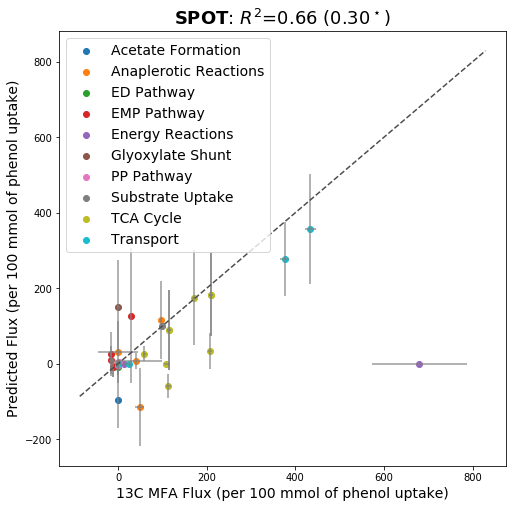

In [9]:
flux_prediction_scatterplot(wt_phenol_fluxes, substrate='phenol', method='SPOT', strain='WT', output_dir=output_dir)

### 5. Compare PVHG6 phenol SPOT flux predictions with 13C-MFA fluxes

Calculate the average and standard deviation of each PVHG6 flux prediction

In [10]:
pvhg6_phenol_fluxes = phenol_fluxes.copy()

# only use the first time point for SPOT analysis
relevant_trials = [
    'phenol_spot_pvhg6_1', 
    'phenol_spot_pvhg6_2', 
    'phenol_spot_pvhg6_3',
]

# make lists to hold average and standard deviation values
average_flux_values = []
std_flux_values = []

# loop over each reaction in the all_trials_phenol_fluxes dataframe
for _, row in all_trials_phenol_fluxes.iterrows():
    
    # make a list of flux values for a given reaction
    flux_values = [row[trial] for trial in relevant_trials]
    
    # calculate average and add to a list
    average = sum(flux_values) / len(relevant_trials)
    average_flux_values.append(average)
    
    # calculate standard deviation and add to a list
    std = np.std(flux_values)
    std_flux_values.append(std)

# use the average and standard deviation lists to add columns to the 13C dataframe
pvhg6_phenol_fluxes['SPOT PVHG6 Flux'] = average_flux_values
pvhg6_phenol_fluxes['SPOT PVHG6 Flux Std'] = std_flux_values

pvhg6_phenol_fluxes.head()

,Pathway,Reaction Ids,Reaction,Location on map,13C Flux,13C Lower Bound,13C Upper Bound,SPOT PVHG6 Flux,SPOT PVHG6 Flux Std
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000,1.000000e+02,3.069895e-14
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306,0.000000e+00,0.000000e+00
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683,3.680165e-07,5.204539e-07
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683,4.004506e-07,5.663227e-07
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683,-1.333779e+01,4.146622e+00


Save PVHG6 phenol SPOT central flux predictions

In [11]:
pvhg6_phenol_fluxes.to_csv('../data/central_fluxes/phenol_SPOT_PVHG6.csv', index=False)

Plot phenol SPOT fluxes vs 13C-MFA fluxes

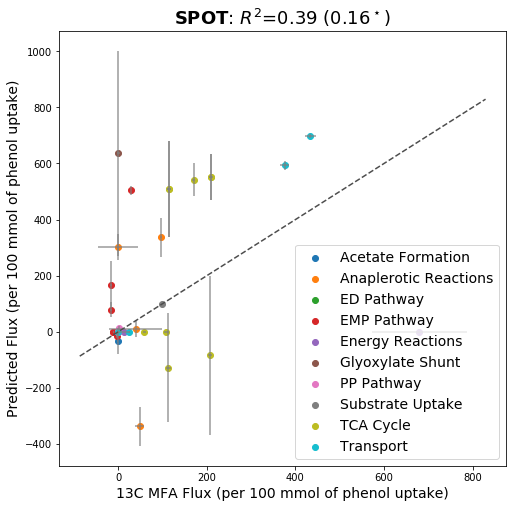

In [12]:
flux_prediction_scatterplot(pvhg6_phenol_fluxes, substrate='phenol', method='SPOT', strain='PVHG6', output_dir=output_dir)

### 6. Generate wildtype and PVHG6 SPOT flux maps

Make flux map for wildtype with glucose

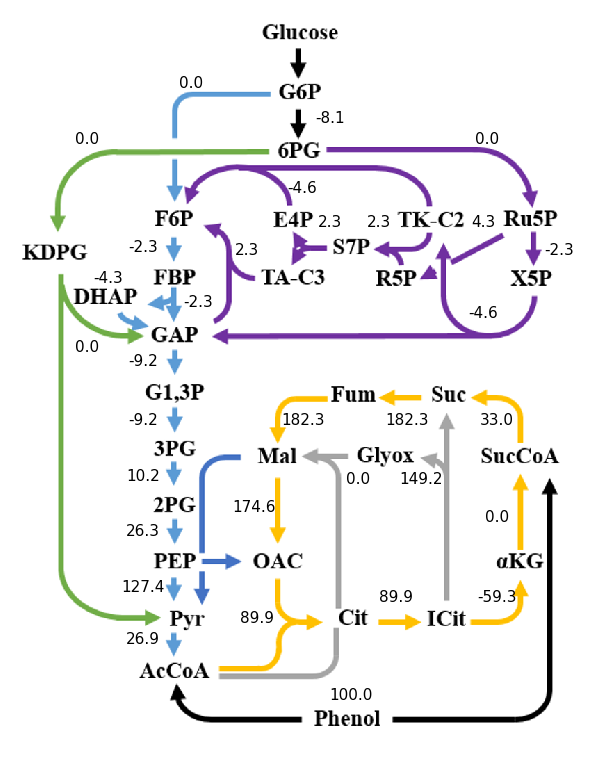

In [13]:
generate_flux_map(wt_phenol_fluxes, 'SPOT WT Flux', substrate='phenol', method='SPOT', strain="WT", output_dir=output_dir)

Make the flux map for PVHG6 with phenol

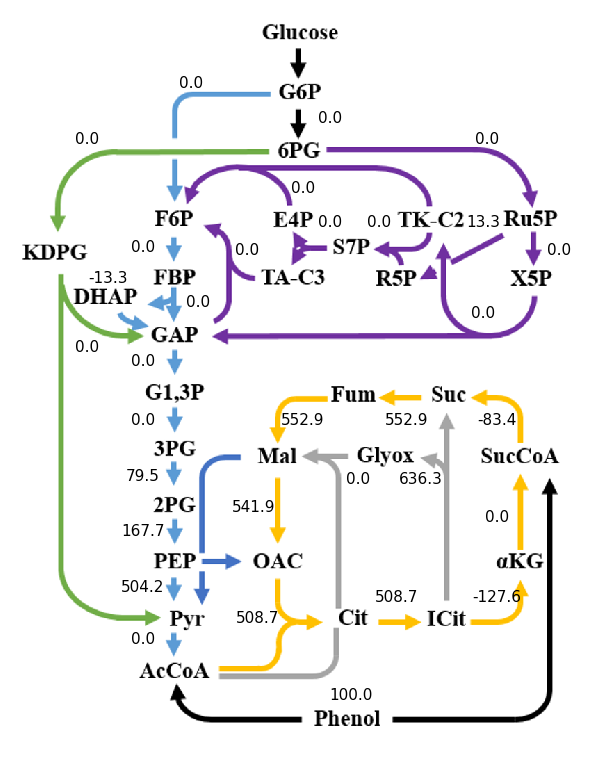

In [14]:
generate_flux_map(pvhg6_phenol_fluxes, 'SPOT PVHG6 Flux', substrate='phenol', method='SPOT', strain="PVHG6", output_dir=output_dir)

### 7. Add wildtype and PVHG6 SPOT phenol data to growth parameters data

Load experimental growth parameters and SPOT predictions from notebook G

In [15]:
spot_growth_parameters

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,NaN,NaN
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,NaN,NaN
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0


Calculate predicted growth rate average and standard deviation for wildtype phenol using SPOT

In [16]:
# only use the wildype for SPOT analysis
relevant_trials = [
    'phenol_spot_wt_1', 
    'phenol_spot_wt_2', 
    'phenol_spot_wt_3',
]

# get experimental uptake rate from dataframe
experimental_uptake_rate = spot_growth_parameters.loc['WT-P', 'substrate consumption rate']

# isolate the row with the growth fluxes
growth_flux_row = all_trials_phenol_fluxes[all_trials_phenol_fluxes.Pathway == 'Biomass Equation']

# make a list of the relevant growth rates
growth_fluxes = [growth_flux_row[trial].values[0] for trial in relevant_trials]

# calculate scale factor
scale_factor = -1 * experimental_uptake_rate / normalized_uptake_rate

# calculate growth rat with growth flux and scale factor
growth_rates = [scale_factor * growth_flux for growth_flux in growth_fluxes]

# calculate the average and standard deviations of growth rates
wt_spot_growth_rate = sum(growth_rates) / len(growth_rates)
wt_spot_growth_rate_std = np.std(growth_rates)

Calculate predicted growth rate average and standard deviation for PVHG6 phenol using SPOT

In [17]:
# only use the wildype for SPOT analysis
relevant_trials = [
    'phenol_spot_pvhg6_1', 
    'phenol_spot_pvhg6_2', 
    'phenol_spot_pvhg6_3',
]

# get experimental uptake rate from dataframe
experimental_uptake_rate = spot_growth_parameters.loc['WT-P', 'substrate consumption rate']

# isolate the row with the growth fluxes
growth_flux_row = all_trials_phenol_fluxes[all_trials_phenol_fluxes.Pathway == 'Biomass Equation']

# make a list of the relevant growth rates
growth_fluxes = [growth_flux_row[trial].values[0] for trial in relevant_trials]

# calculate scale factor
scale_factor = -1 * experimental_uptake_rate / normalized_uptake_rate

# calculate growth rat with growth flux and scale factor
growth_rates = [scale_factor * growth_flux for growth_flux in growth_fluxes]

# calculate the average and standard deviations of growth rates
pvhg6_spot_growth_rate = sum(growth_rates) / len(growth_rates)
pvhg6_spot_growth_rate_std = np.std(growth_rates)

Add SPOT phenol data to growth rate data

In [18]:
# get values added in notebook G
spot_growth_rate_glucose = float(spot_growth_parameters.loc['WT-G']['SPOT growth rate'])
spot_growth_rate_std_glucose = float(spot_growth_parameters.loc['WT-G']['SPOT growth std'])


spot_growth_parameters['SPOT growth rate'] = [
    wt_spot_growth_rate, 
    pvhg6_spot_growth_rate, 
    spot_growth_rate_glucose
]
spot_growth_parameters['SPOT growth std'] = [
    wt_spot_growth_rate_std, 
    pvhg6_spot_growth_rate_std, 
    spot_growth_rate_std_glucose
]

spot_growth_parameters

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,0.0,0.0
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0


Save SPOT growth rates

In [19]:
spot_growth_parameters.to_csv('../data/growth_parameters/spot_growth_parameter.csv', index=True, header=True)

Plot SPOT growth rate predictions

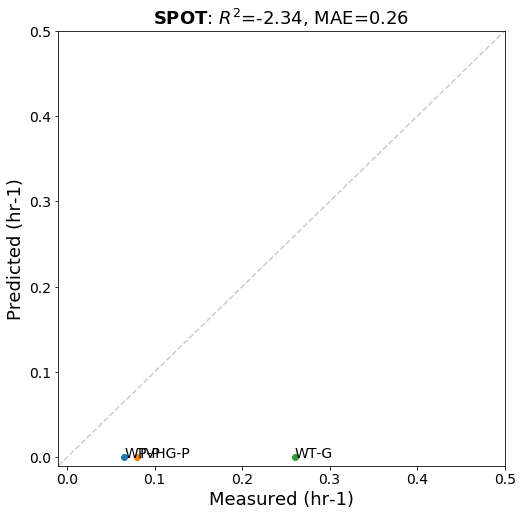

In [20]:
growth_rate_scatterplot(
    spot_growth_parameters,
    'SPOT',
    [-0.01, 0.5], # x limits
    [-0.01, 0.5], # y limits
    output_dir=output_dir
)